In [ ]:
# Install only missing libraries
!pip install datasets fiftyone --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.1 MB/s eta

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, ViTModel
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from PIL import Image, UnidentifiedImageError

In [ ]:
feature_extractor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset
from PIL import Image, UnidentifiedImageError

# Load only 100 examples to reduce memory pressure
raw_dataset = load_dataset("merve/vqav2-small", split="validation[:1000]")

# Sanitize image data
clean_data = []
for item in raw_dataset:
    try:
        img = item["image"]
        if not isinstance(img, Image.Image):
            img = Image.open(img).convert("RGB")
        clean_data.append({
            "image": img,
            "question": item["question"],
            "answer": item["multiple_choice_answer"]
        })
    except (UnidentifiedImageError, OSError):
        continue

print(f"Loaded {len(clean_data)} clean examples")


Loaded 1000 clean examples


In [ ]:
unique_answers = sorted(set(item["answer"] for item in clean_data))
label2id = {label: i for i, label in enumerate(unique_answers)}
id2label = {i: label for label, i in label2id.items()}

# Step 6: Define Dataset
class VQADataset(Dataset):
    def __init__(self, data, feature_extractor, tokenizer, label2id):
        self.data = data
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.label2id = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_input = self.feature_extractor(images=item["image"], return_tensors="pt")
        question_input = self.tokenizer(item["question"], return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            image_feat = vit(**image_input).last_hidden_state.mean(dim=1)
            question_feat = bert(**question_input).last_hidden_state.mean(dim=1)

        combined = torch.cat((image_feat, question_feat), dim=1).squeeze(0)
        label = torch.tensor(self.label2id[item["answer"]])
        return combined, label

In [ ]:
# Step 7: Define Model
class VQAClassifier(nn.Module):
    def __init__(self, input_dim=1536, num_classes=1000):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQAClassifier(num_classes=len(label2id)).to(device)
vit = vit.to(device)
bert = bert.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%")


Epoch 1: Loss=5.8283, Accuracy=5.00%
Epoch 2: Loss=5.4714, Accuracy=30.00%
Epoch 3: Loss=5.1251, Accuracy=31.00%
Epoch 4: Loss=4.8330, Accuracy=32.00%
Epoch 5: Loss=4.3051, Accuracy=32.00%
Epoch 6: Loss=3.8403, Accuracy=32.00%
Epoch 7: Loss=3.3992, Accuracy=30.00%
Epoch 8: Loss=3.0082, Accuracy=29.00%
Epoch 9: Loss=2.8530, Accuracy=32.00%
Epoch 10: Loss=2.4868, Accuracy=39.00%


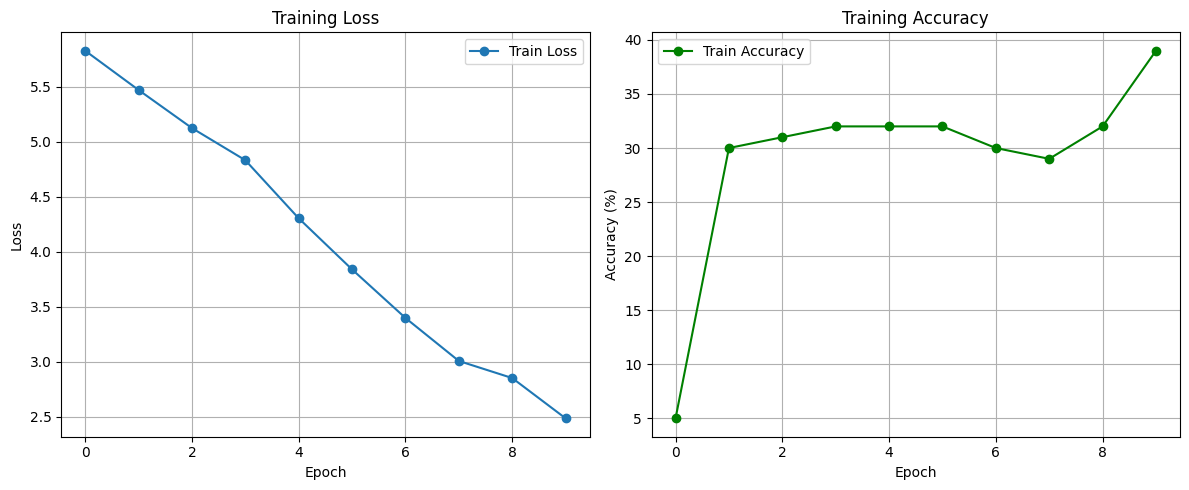

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def predict(image: Image.Image, question: str, model, vit, bert, feature_extractor, tokenizer, label2id, id2label, device):
    model.eval()
    with torch.no_grad():
        # Preprocess image and question
        image_input = feature_extractor(images=image, return_tensors="pt").to(device)
        question_input = tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)

        # Extract features
        image_feat = vit(**image_input).last_hidden_state.mean(dim=1)
        question_feat = bert(**question_input).last_hidden_state.mean(dim=1)

        # Concatenate and predict
        combined = torch.cat((image_feat, question_feat), dim=1)
        output = model(combined)

        # Get top prediction
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_answer = id2label[predicted_class]

    return predicted_answer


In [ ]:
from PIL import Image

# Replace with your own image path or use one from clean_data
test_image = clean_data[0]["image"]
test_question = "which muscle is man in the image traning?"

# Get answer
predicted_answer = predict(
    image=test_image,
    question=test_question,
    model=model,
    vit=vit,
    bert=bert,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    label2id=label2id,
    id2label=id2label,
    device=device
)

print(f"Q: {test_question}")
print(f"A: {predicted_answer}")


Q: which muscle is man in the image traning?
A: back


In [ ]:
import os

# Create a project folder
project_name = "vqa-transformers-project"
os.makedirs(project_name, exist_ok=True)

# Move notebook (you'll need to save it first)
from google.colab import drive
drive.mount('/content/drive')  # if you want to use Google Drive

# Save your current notebook
# File → Save a copy in Drive → then download manually or move

# Create placeholder files for demo
with open(f"{project_name}/README.md", "w") as f:
    f.write("# VQA Transformers Project\n\nWork in progress...")

with open(f"{project_name}/requirements.txt", "w") as f:
    f.write("torch\ntransformers\ndatasets\npillow\n")

# (Optional) Copy an image if you have one
# !cp /content/sample_image.jpg /content/vqa-transformers-project/


Mounted at /content/drive


In [ ]:
import zipfile

zipf = zipfile.ZipFile(f"{project_name}.zip", 'w')
for root, dirs, files in os.walk(project_name):
    for file in files:
        zipf.write(os.path.join(root, file))
zipf.close()

from google.colab import files
files.download(f"{project_name}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>